# Chapter 3. Decompose oncogenic-activation signature and define transcriptional components

<br>
<div>
    <img src="../media/method_chap2.png" width=2144 height=1041>
</div>

### Analysis overview
In this chapter we will use the KRAS oncogenic signature genes that we generated in chapter 2 and we will decomposed them into non-negative matrix factorization components.

To perfrom this analysis we will use as reference dataset 750 samples from the Broad-Novartis Cancer Cell Line Encyclopedia (CCLE) ([*Barretina et al. 2012*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3320027/)). This dataset, hereafter denoted as $A^{n \times m}$, contains as rows the oncogenic signature genes and  samples representing many instances of the cellular states of interest. 

The decomposition is based on a Non-Negative Matrix Factorization (NMF) algorithm ([*Brunet et al. 2004*](https://www.ncbi.nlm.nih.gov/pubmed/15016911); [*Tamayo et al. 2007*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1838404/)). These transcriptional components represent summaries of the most coherent gene expression patterns, relevant to the KRAS signature genes across the wide variety of cellular states and contexts represented in the reference dataset. The methodology contains the following analysis tasks:


*	*Normalization*. Normalize the input matrix $A^{n \times m}$ by replacing each gene expression entry by its column rank and obtain matrix $A^{n \times m}_{norm}$.


*	*Matrix Factorization.* Perform a standard non-negative matrix factorization (NMF) ([*Brunet et al. 2004*](https://www.ncbi.nlm.nih.gov/pubmed/15016911); [*Tamayo et al. 2007*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1838404/), [*Cichocki et al. 2008*](http://www.bsp.brain.riken.jp/publications/2007/Cichocki-Zd-Amar_SPMAG.pdf))

<div>
    <img src="../media/chap3_equation.png" width=200 height=50>
</div>

*    The resulting matrices $W^{n \times k}$ and $H^{k \times m}$ have lower rank than the original matrix $A^{n \times m}_{norm}$ with $k << n, m$.


*	*Model selection.* Find an optimal number of components $k_{c}$ based on the numerical stability of multiple projections using different random seeds  ([*Brunet et al. 2004*](https://www.ncbi.nlm.nih.gov/pubmed/15016911)). The peaks of the cophenetic coefficient represent the more stable decompositions. 


The Matrix $H^{k \times m}$ has the same number of samples as $A^{n \times m}$ but a smaller number of rows and can be interpreted as a summarized version of the original dataset, i.e., one described in the space of the most salient transcriptional programs (components) rather than the original variables (genes). In the KRAS analysis performed below this procedure will produce 9 transcriptional components C1-C9. Restricting the decomposition process to operate using only the signature genes allowed us to emphasize the most relevant oncogene-driven transcriptional space and limit the effects of other transcriptional differences.


### 1. Set up notebook and import [CCAL](https://github.com/KwatME/ccal)

In [1]:
from notebook_environment import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

### 2. Select KRAS signature gene rows from reference dataset (CCLE gene expression)

In [4]:
# Load kras signature genes file
#kras_relevant_genes = pd.read_table(
    #'', squeeze=True)

# Select kras signature gene rows from CCLE gene expression
rpkm__kras_relevant_gene_x_ccle_cellline = pd.read_table('upgenes_stats.txt', index_col=0)

# Print CCLE gene expression of kras signature genes
rpkm__kras_relevant_gene_x_ccle_cellline

RENCA.CTL.LAWSON..Gene..Statistic.Value  \
row_id                                              
ERP44                                        9.65   
FAS                                          9.05   
ICAM1                                        7.16   
UBE2G2                                       6.70   
KDELR2                                       6.29   
KAT7                                         5.75   
SEL1L                                        5.54   
ELOF1                                        5.32   
AP2M1                                        5.18   
NDUFV1                                       5.11   
PRKCSH                                       4.86   
SMG7                                         4.35   
PSME1                                        4.15   
OTUD5                                       -4.05   
LENG8                                        3.90   
RBM15                                        3.63   
DPF2                                         3.55   
RCE1                                         3.41   
FIBP                                         3.41   
NDUFS1                                       3.40   
CYB5R4                                       3.37   
ANKS3                                        3.37   
PET100                                       3.28   
ATXN7L3                                      3.24   
CARD10                                       3.22   
PSME2                                        3.02   
PKNOX1                                       3.01   
PTEN                                         2.94   
IFNAR1                                       2.90   
SURF1                                        2.90   
...                                           ...   
SQSTM1                                      -0.21   
CASP3                                       -0.12   
NOP58                                         NaN   
ERAP1                                        8.12   
PDIA3                                        7.97   
TNFRSF1B                                     4.71   
STAT2                                        4.59   
TRADD                                        4.00   
EIF3L                                        3.65   
ATP5SL                                       3.63   
KMT2A                                        3.10   
ARID1A                                       2.00   
ADO                                          1.76   
WDR24                                        1.33   
NF2                                          0.17   
RC3H1                                        0.14   
CALR                                         3.10   
FADD                                        -2.99   
MEN1                                         2.57   
CASP8                                        1.91   
IFNGR2                                      12.76   
TAP2                                        12.37   
TAP1                                        10.03   
IFNGR1                                      13.01   
B2M                                         10.94   
JAK2                                        10.15   
TNFRSF1A                                     8.20   
TAPBP                                        7.42   
STAT1                                       16.50   
JAK1                                        21.30   

          EMT6.CTL.LAWSON..Gene..Statistic.Value  \
row_id                                             
ERP44                                       6.16   
FAS                                         4.43   
ICAM1                                      -0.12   
UBE2G2                                      4.57   
KDELR2                                      1.46   
KAT7                                       -1.76   
SEL1L                                      -1.46   
ELOF1                                       3.76   
AP2M1                                       0.56   
NDUFV1                                      0.94   
PRKCSH                                      3.

### 3. Clean up filtered reference dataset

In [5]:
# Drop columns with only 1 unique object
df = ccal.drop_df_slices(
    rpkm__kras_relevant_gene_x_ccle_cellline, 0, max_n_unique_objects=1)

# Drop rows with only 1 unique object
df = ccal.drop_df_slices(df, 1, max_n_unique_objects=1)

# Rank normalize
array_2d = ccal.normalize_2d_array(df.values, 'rank', axis=0)

# Scale
array_2d *= 10000

# Convert to DataFrame
rpkm__kras_relevant_gene_x_ccle_cellline = pd.DataFrame(
    array_2d, index=df.index, columns=df.columns)

Dropping 0 axis-0 slices ...
Dropping 0 axis-1 slices ...


### 4. Generate NMF decompositions of filtered reference dataset

Here we'll explore NMF decompositions ranging from 2 to 12 components.

NMFCC with K = 2 ...
NMFCC with K = 3 ...
NMFCC with K = 5 ...
NMFCC with K = 4 ...
NMFCC with K = 7 ...
NMFCC with K = 6 ...
NMFCC with K = 8 ...
NMFCC with K = 10 ...
NMFCC with K = 9 ...
	K = 3: 1/30 ...
	K = 2: 1/30 ...
	K = 4: 1/30 ...
	K = 5: 1/30 ...
	K = 6: 1/30 ...
	K = 7: 1/30 ...
	K = 8: 1/30 ...
	K = 10: 1/30 ...
	K = 9: 1/30 ...
	K = 2: 11/30 ...
	K = 3: 11/30 ...
	K = 4: 11/30 ...
	K = 2: 21/30 ...
	K = 5: 11/30 ...
	K = 6: 11/30 ...
	K = 3: 21/30 ...
	K = 2: 30/30 - done.
	K = 7: 11/30 ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1152x1152 with 0 Axes>

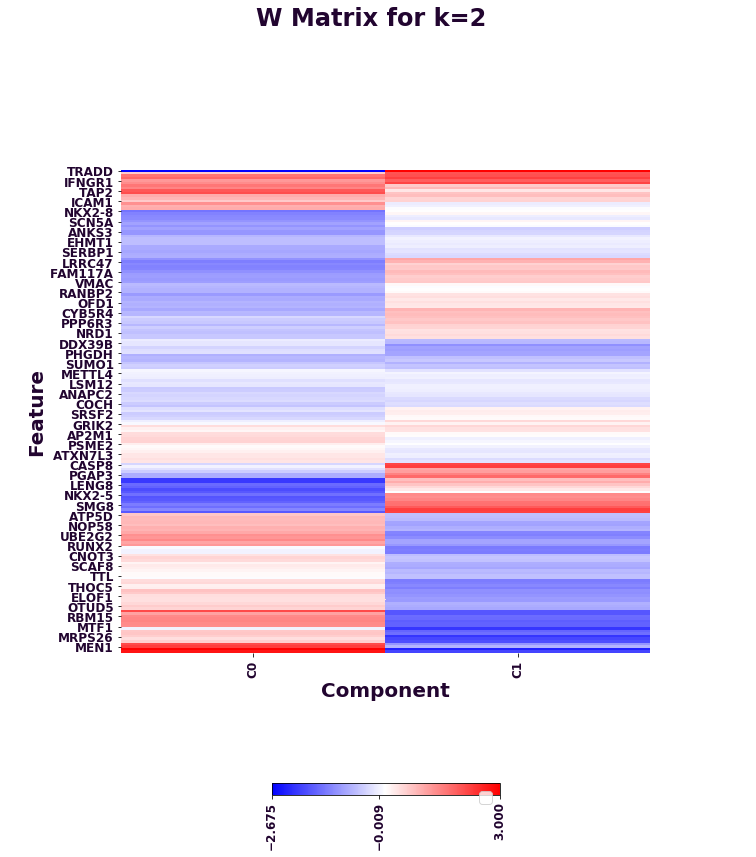

	K = 8: 11/30 ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 4: 21/30 ...


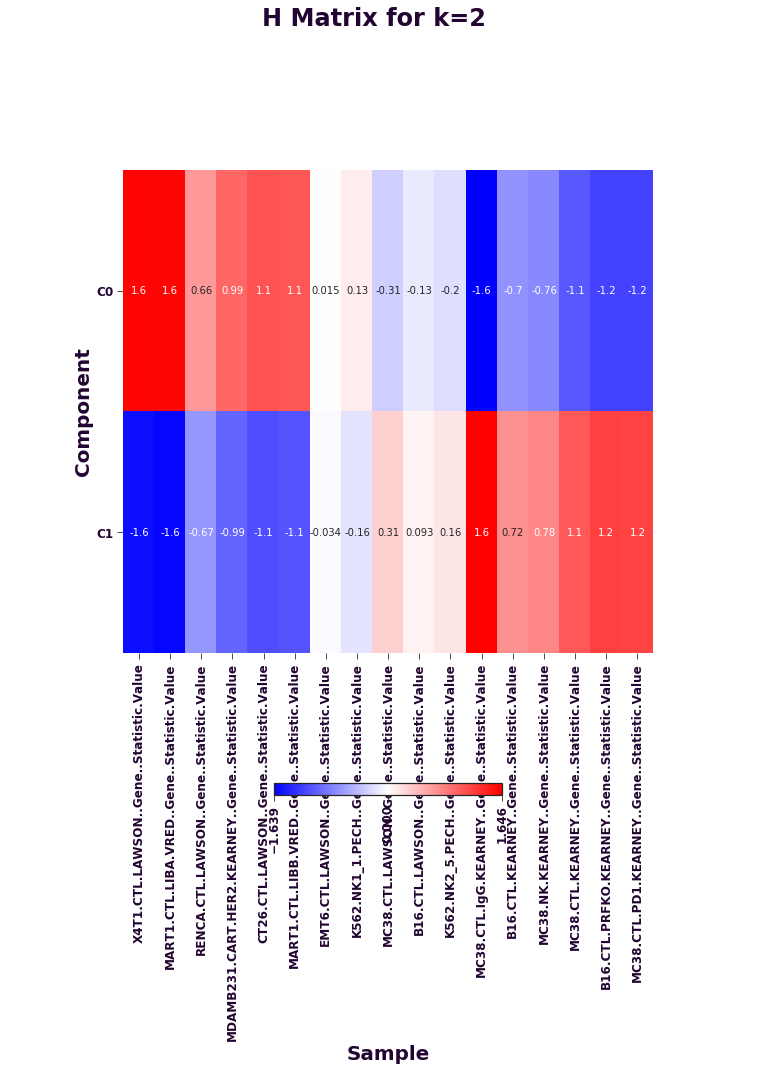

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 3: 30/30 - done.
	K = 10: 11/30 ...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 9: 11/30 ...


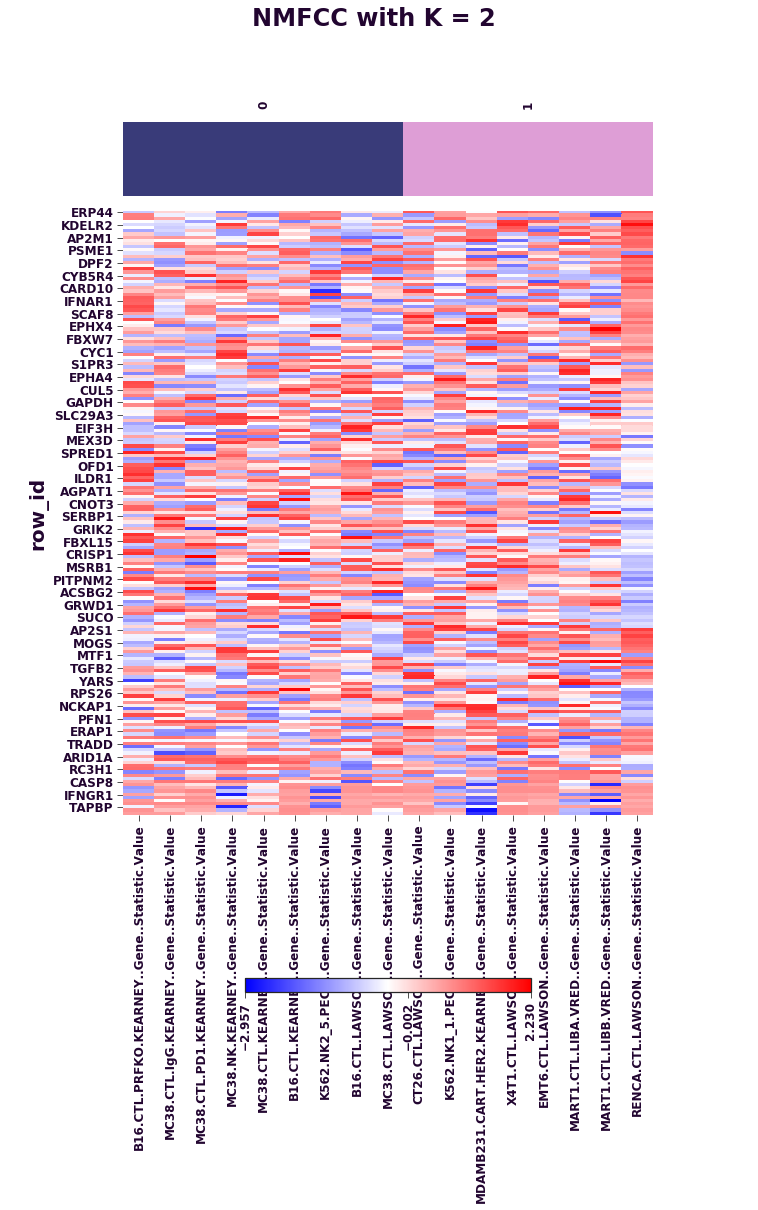

	K = 5: 21/30 ...


<Figure size 1152x1152 with 0 Axes>

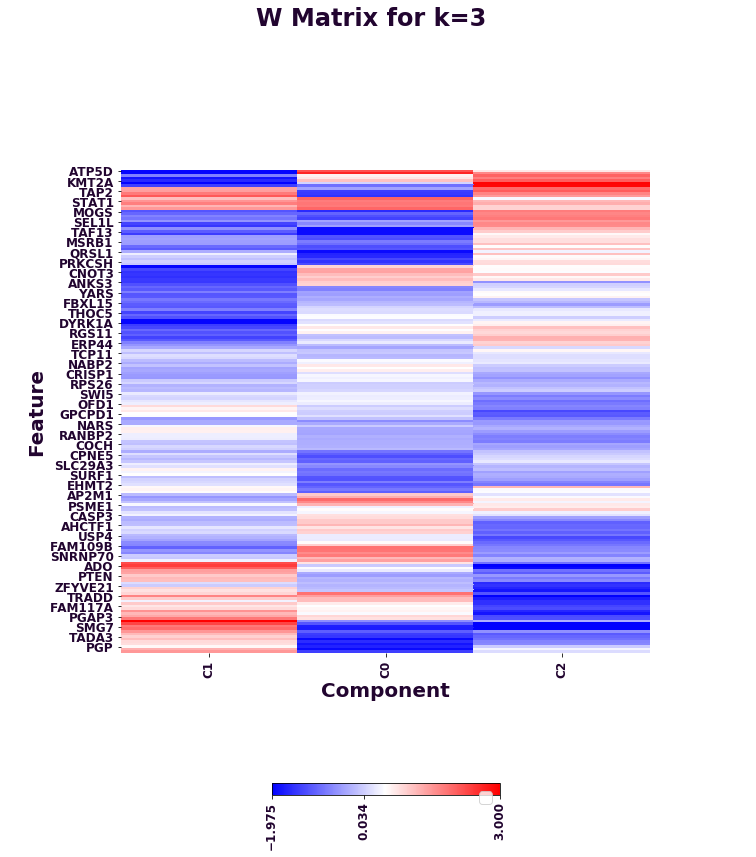

No handles with labels found to put in legend.
No handles with labels found to put in legend.


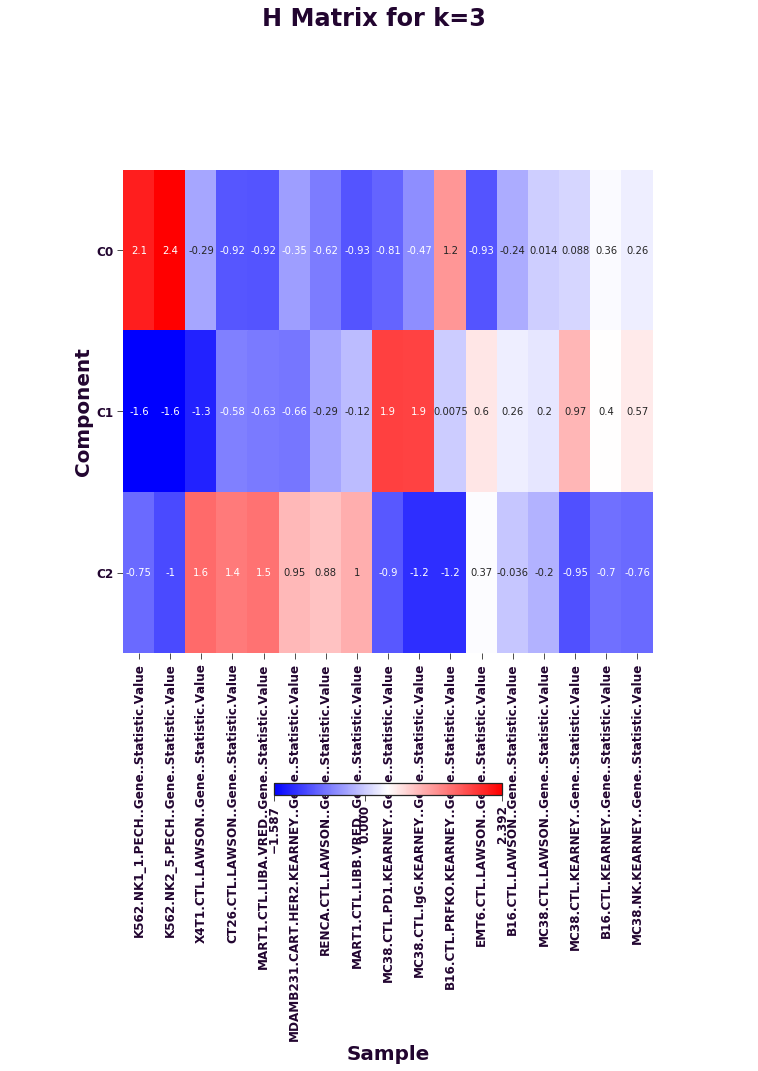

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 6: 21/30 ...
	K = 4: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


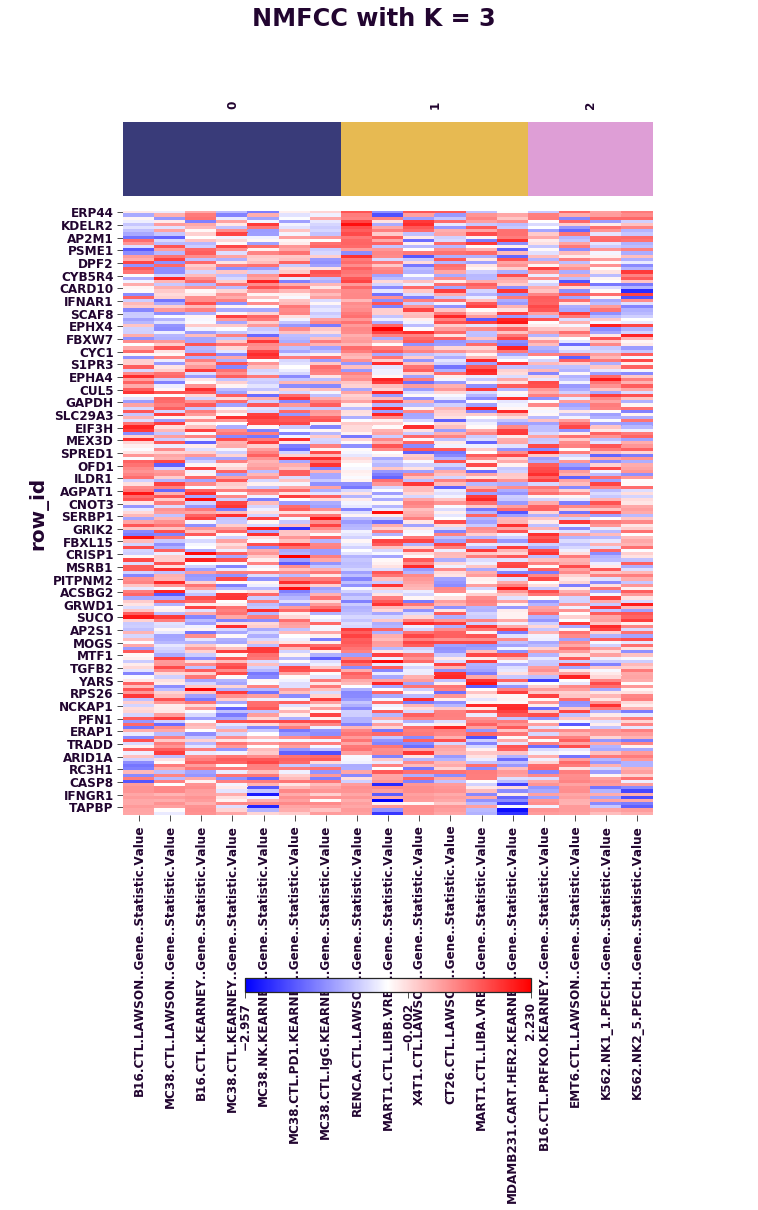

<Figure size 1152x1152 with 0 Axes>

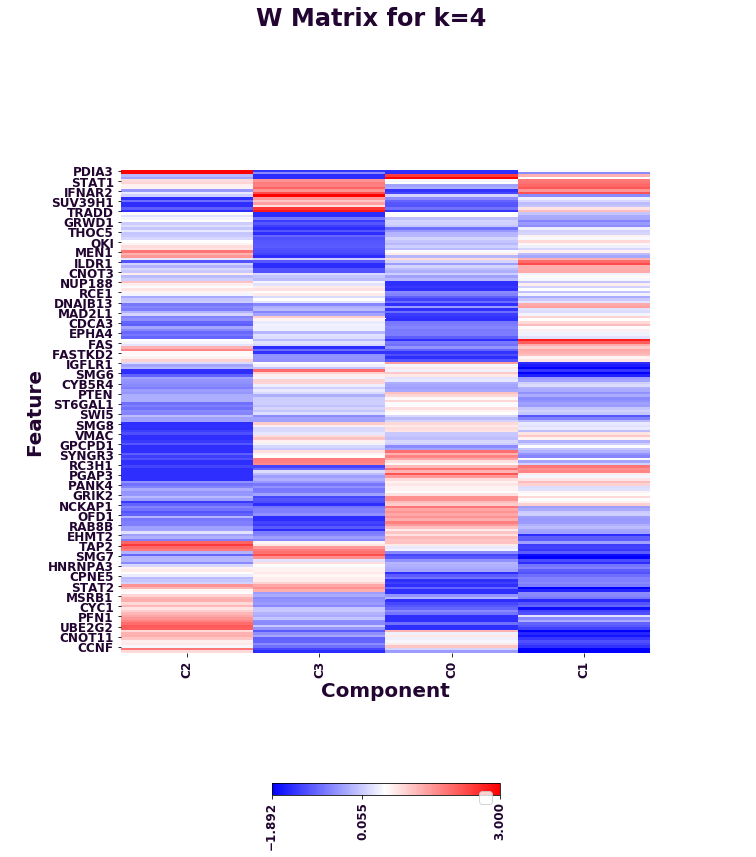

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 7: 21/30 ...


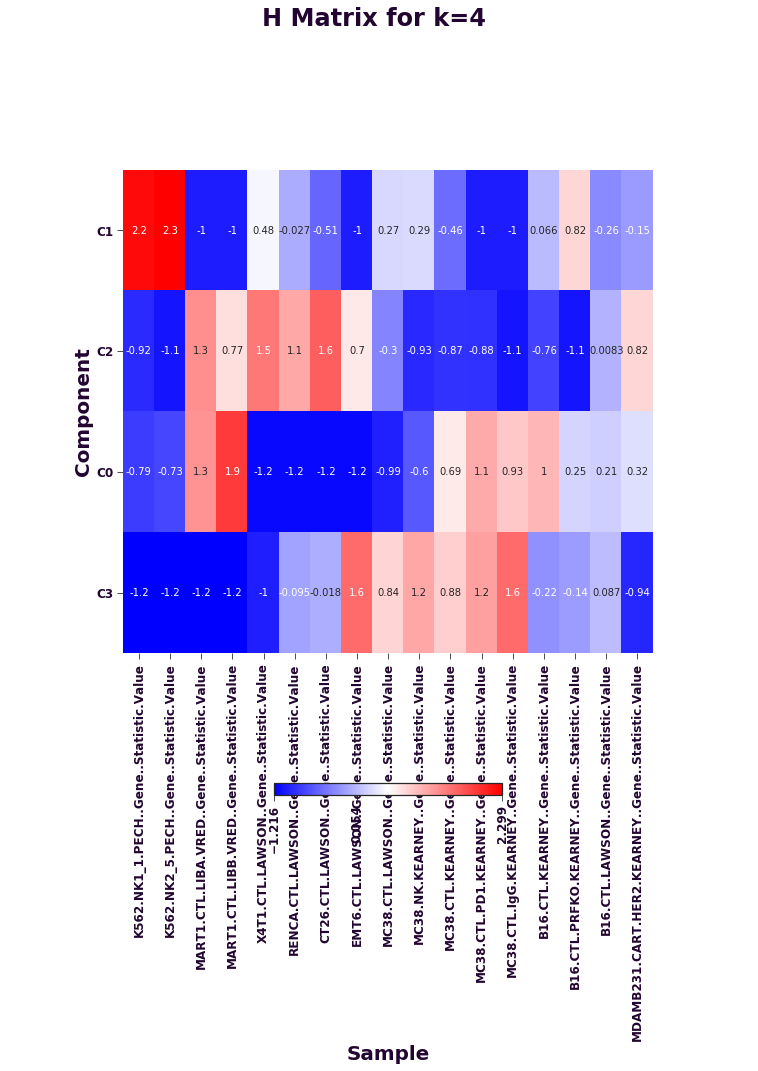

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 5: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 8: 21/30 ...


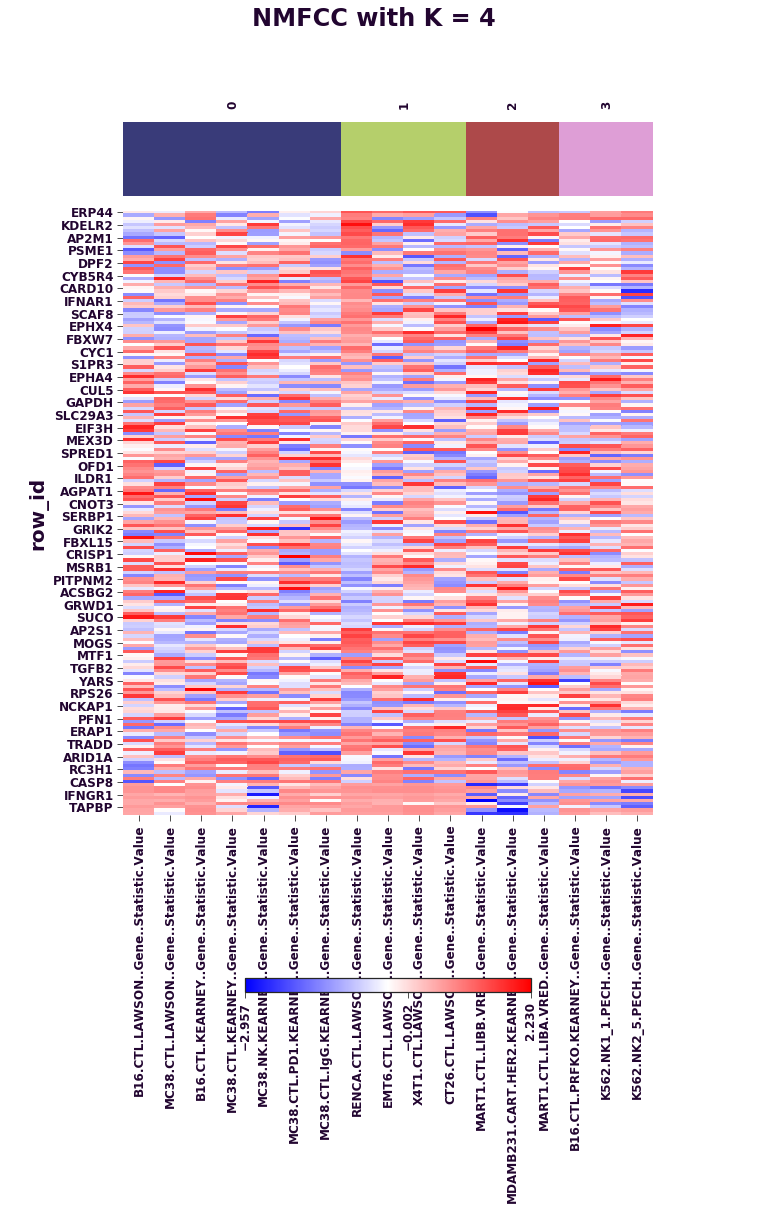

<Figure size 1152x1152 with 0 Axes>

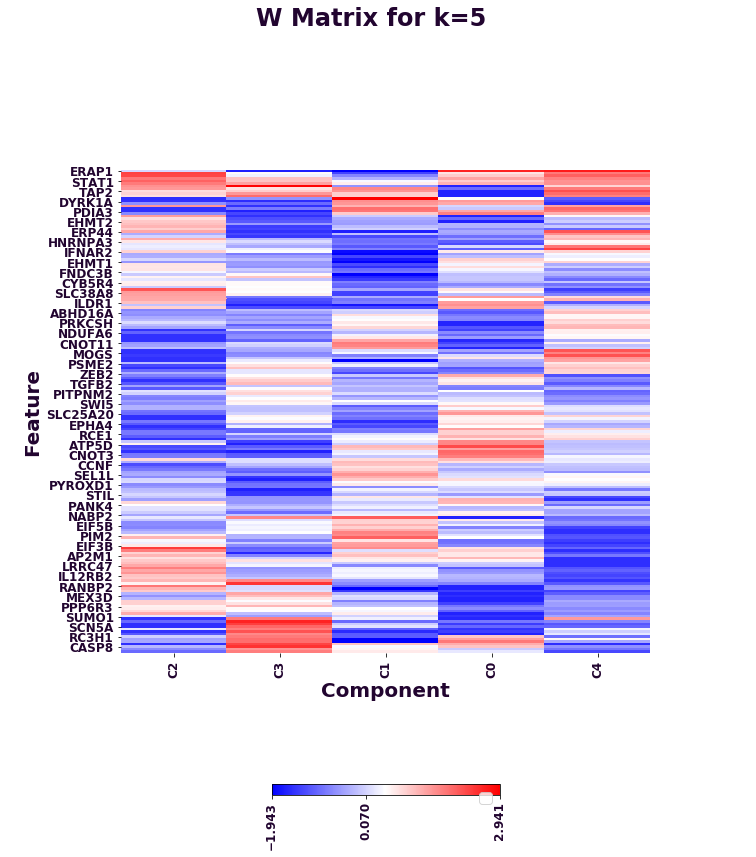

No handles with labels found to put in legend.
No handles with labels found to put in legend.


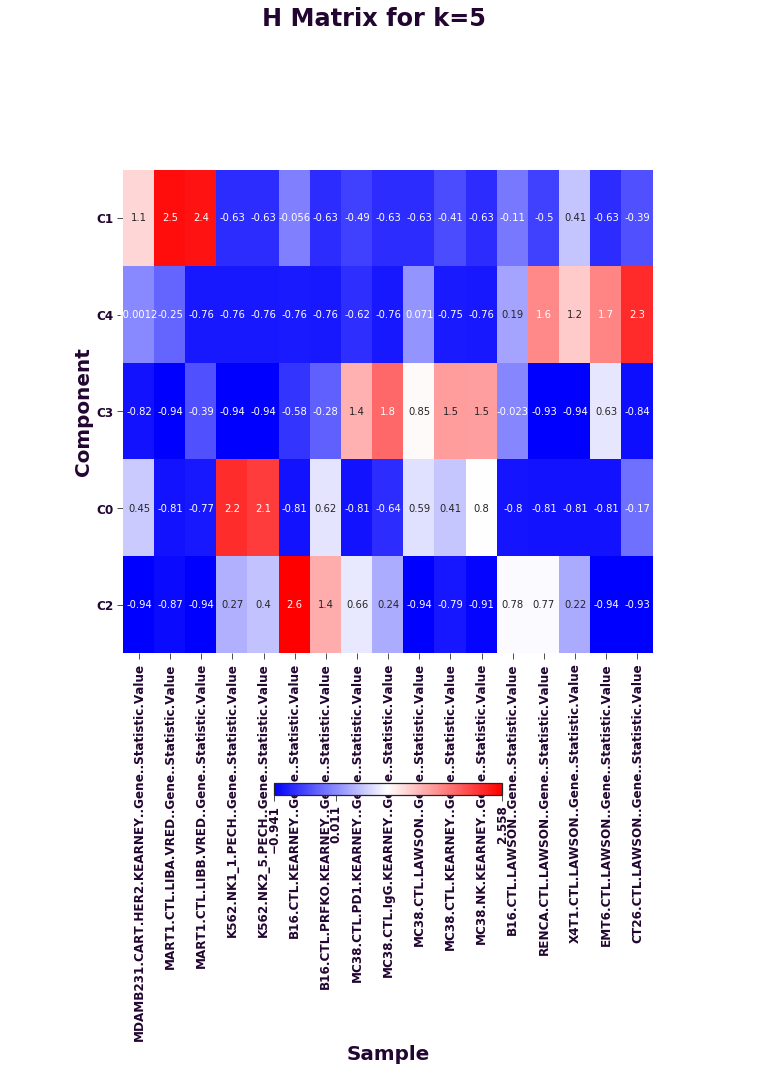

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 6: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1152x1152 with 0 Axes>

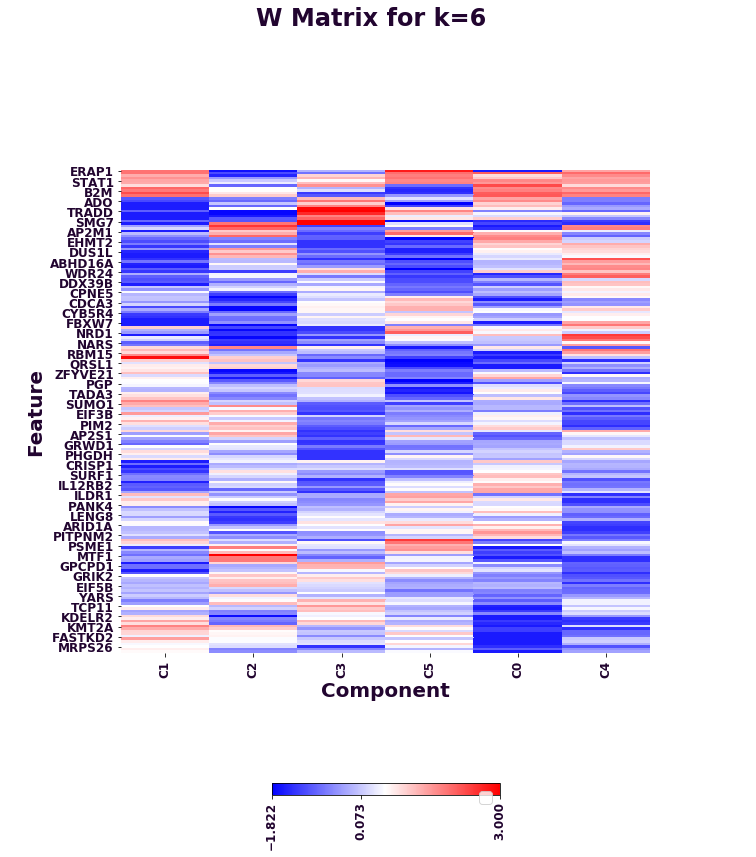

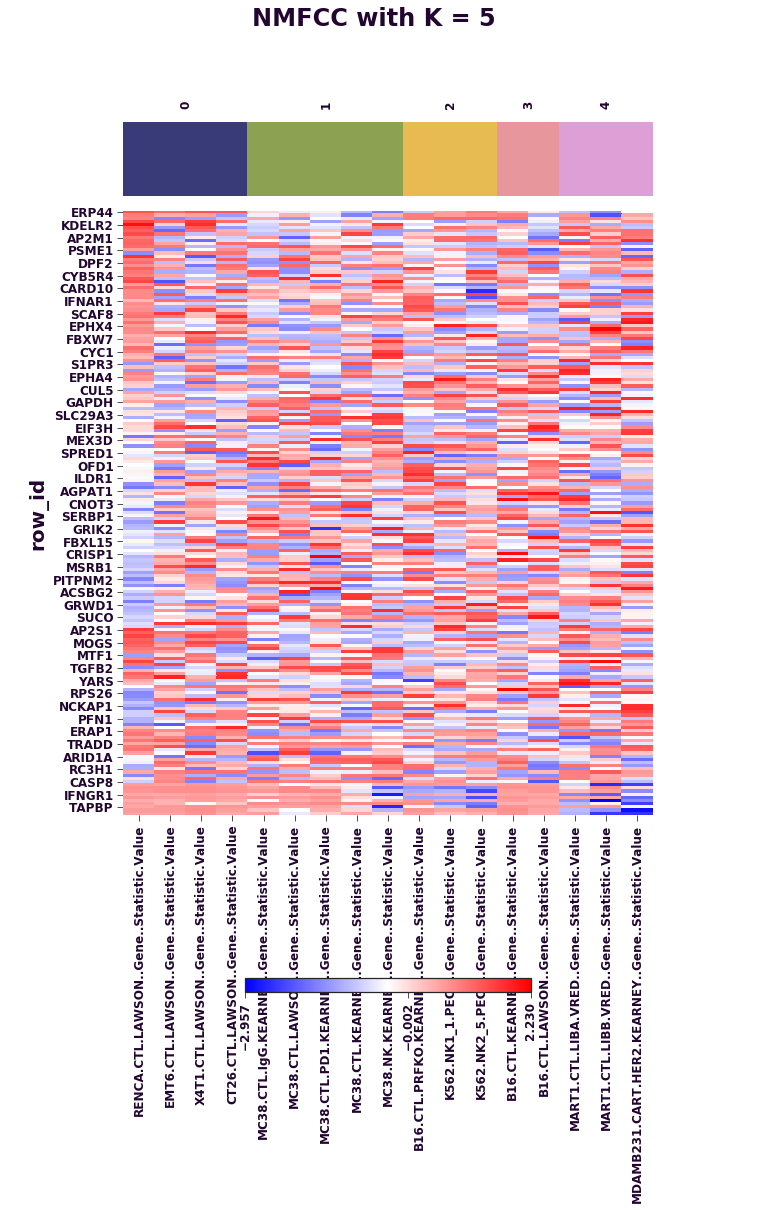

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 10: 21/30 ...
	K = 9: 21/30 ...


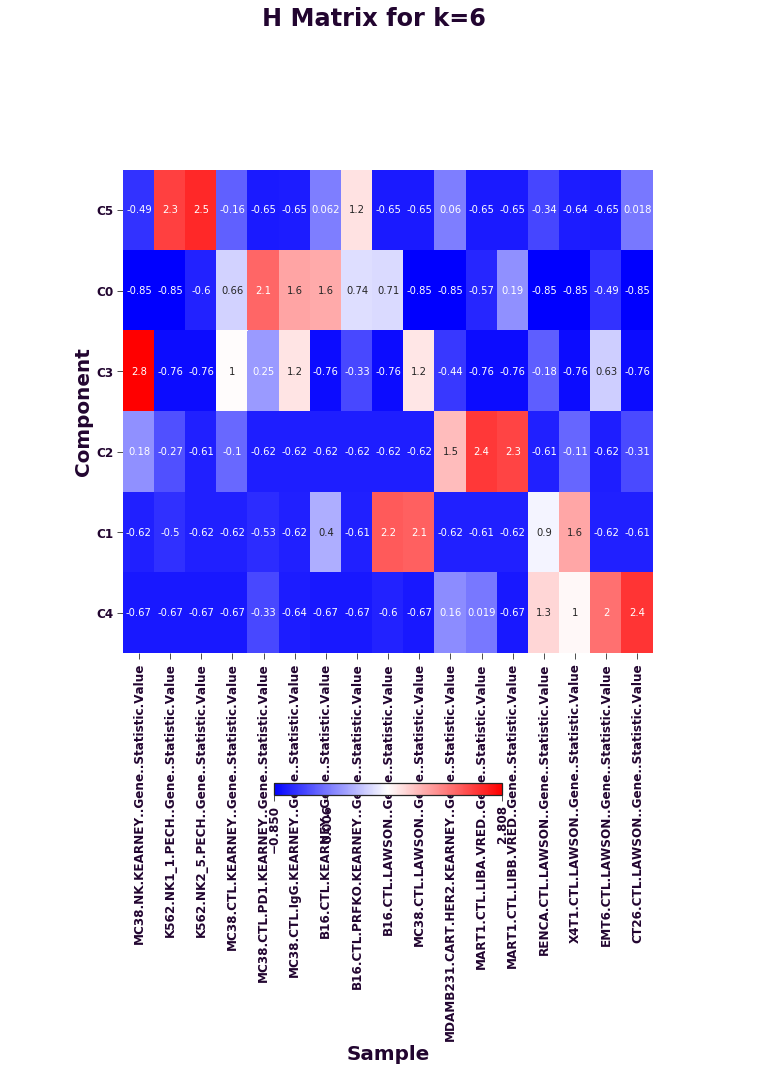

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 7: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


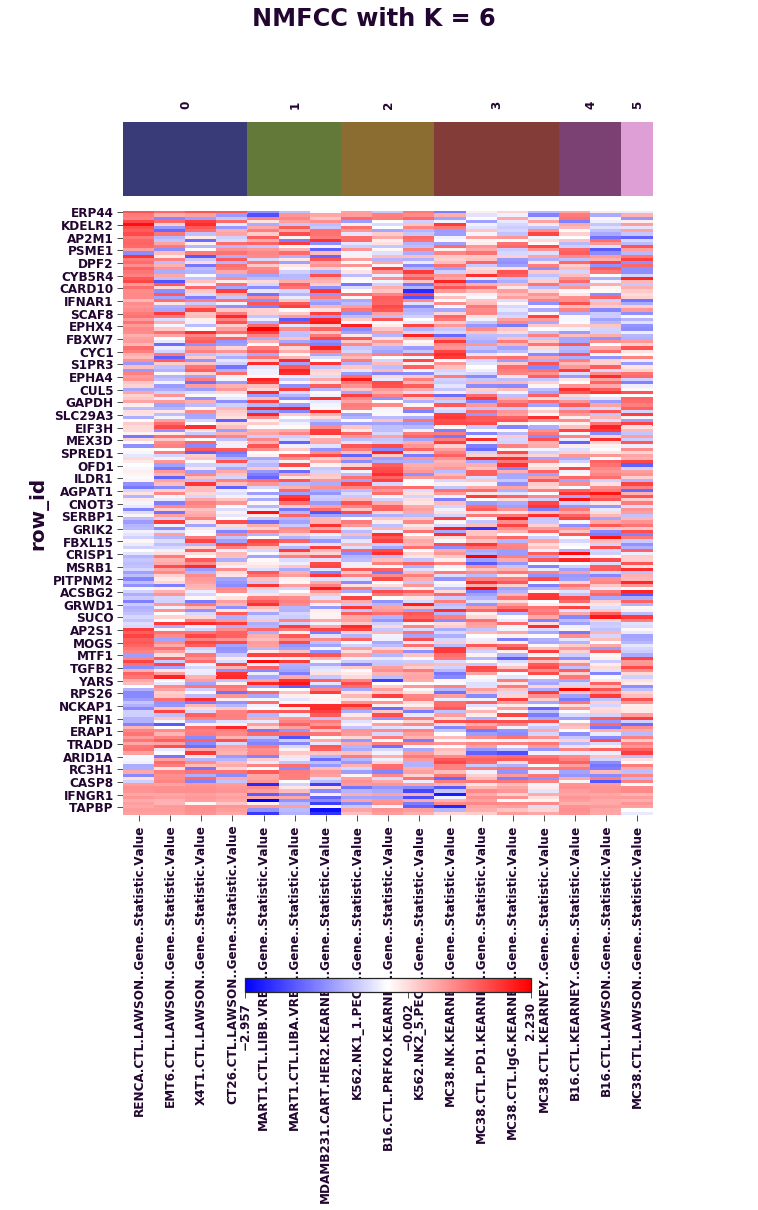

<Figure size 1152x1152 with 0 Axes>

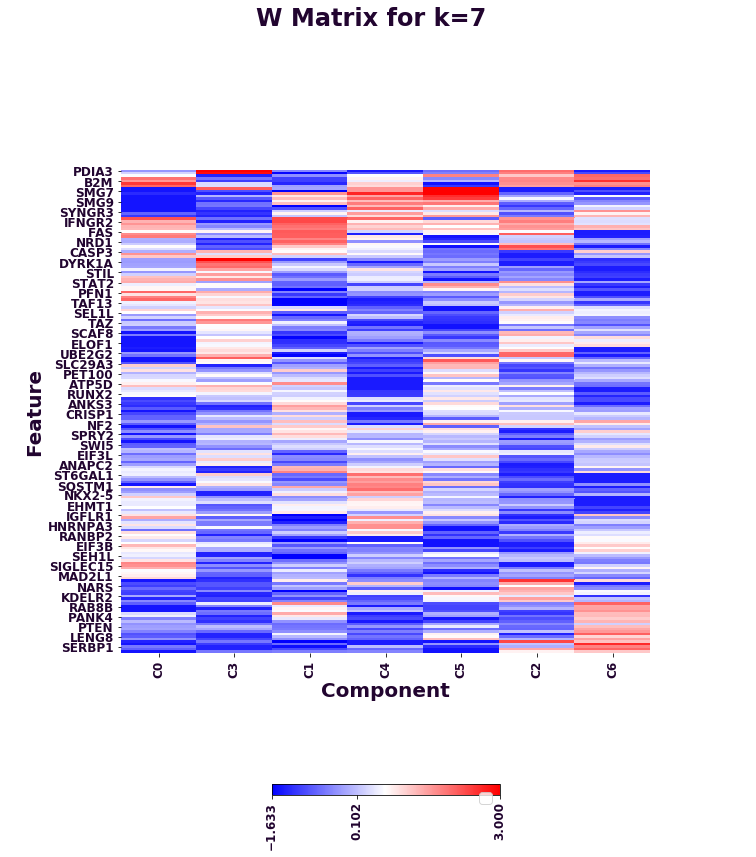

No handles with labels found to put in legend.
No handles with labels found to put in legend.


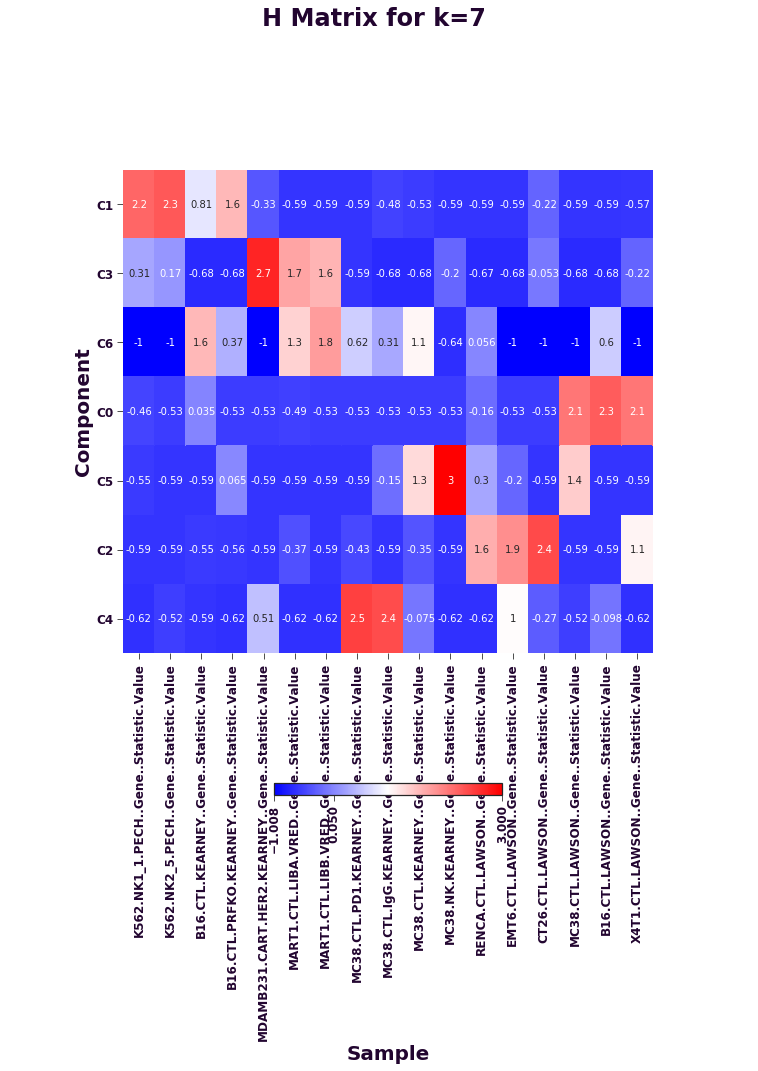

No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 8: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1152x1152 with 0 Axes>

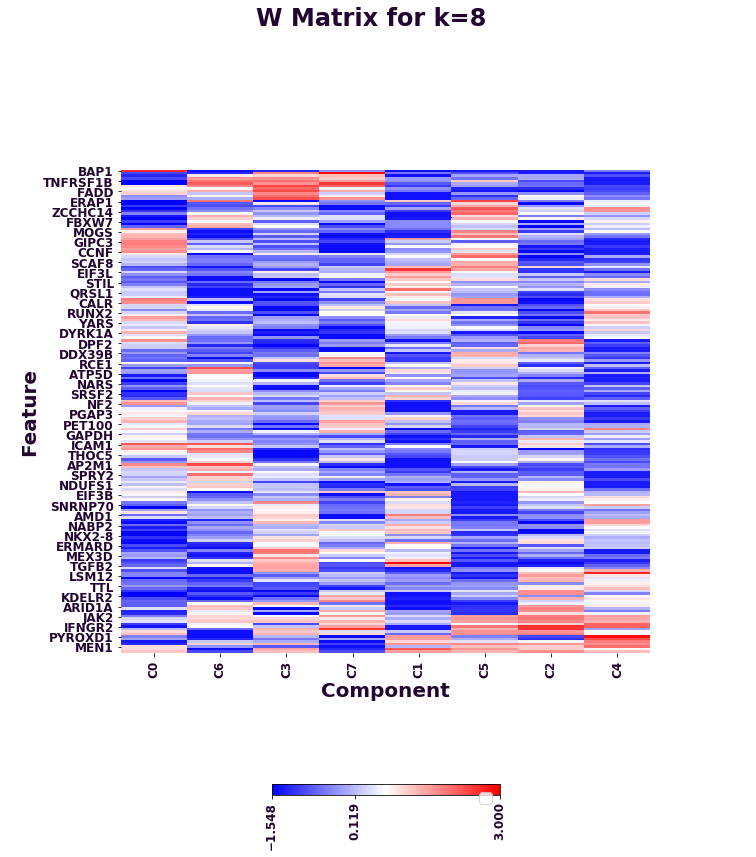

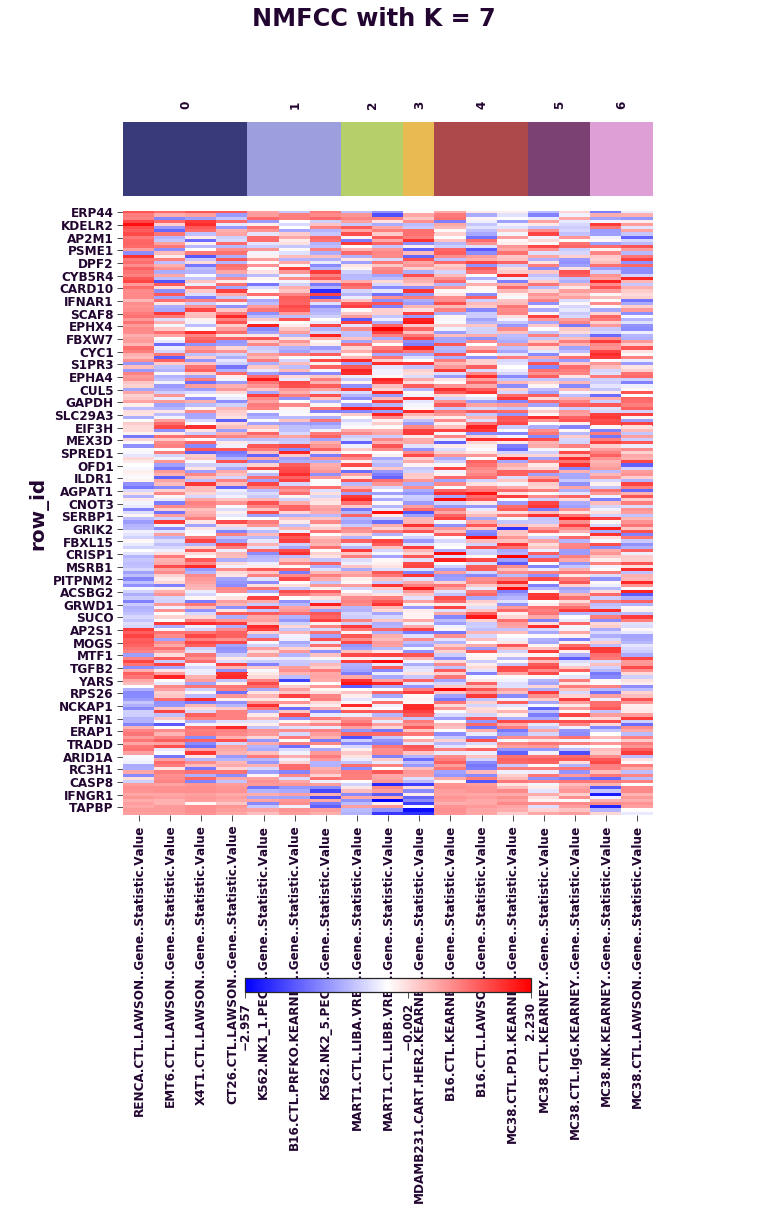

No handles with labels found to put in legend.
No handles with labels found to put in legend.


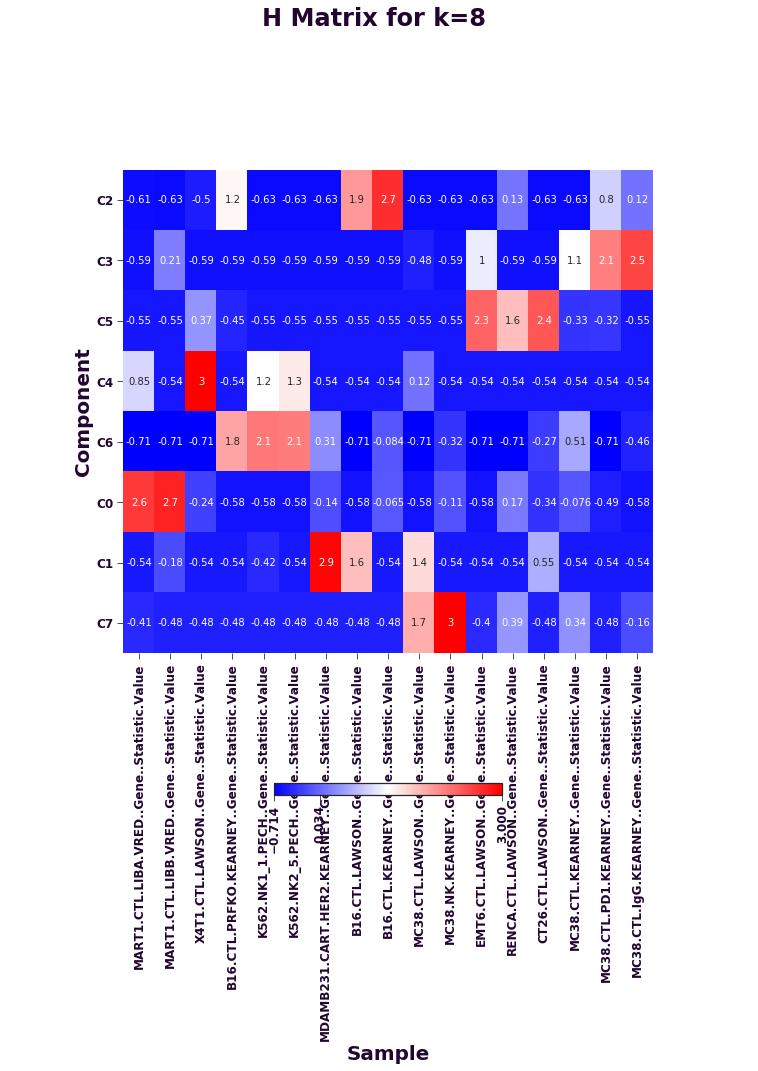

No handles with labels found to put in legend.
No handles with labels found to put in legend.


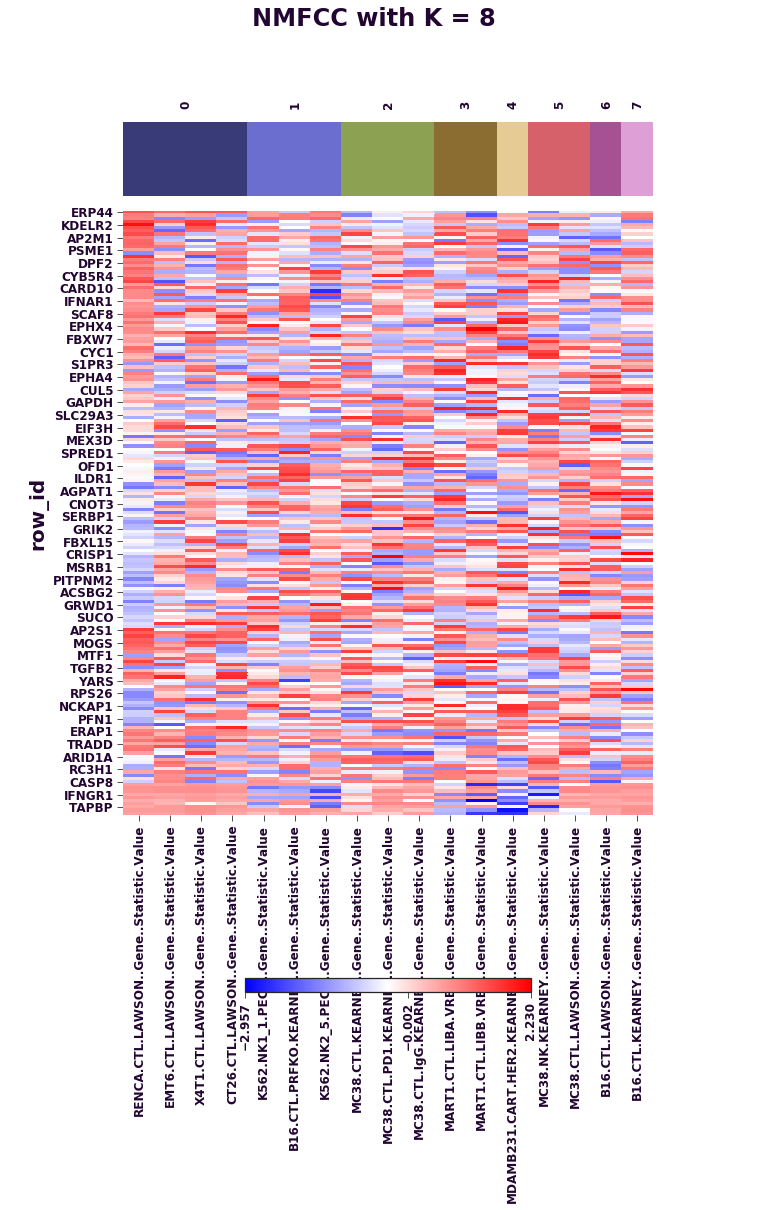

	K = 10: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


	K = 9: 30/30 - done.


No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1152x1152 with 0 Axes>

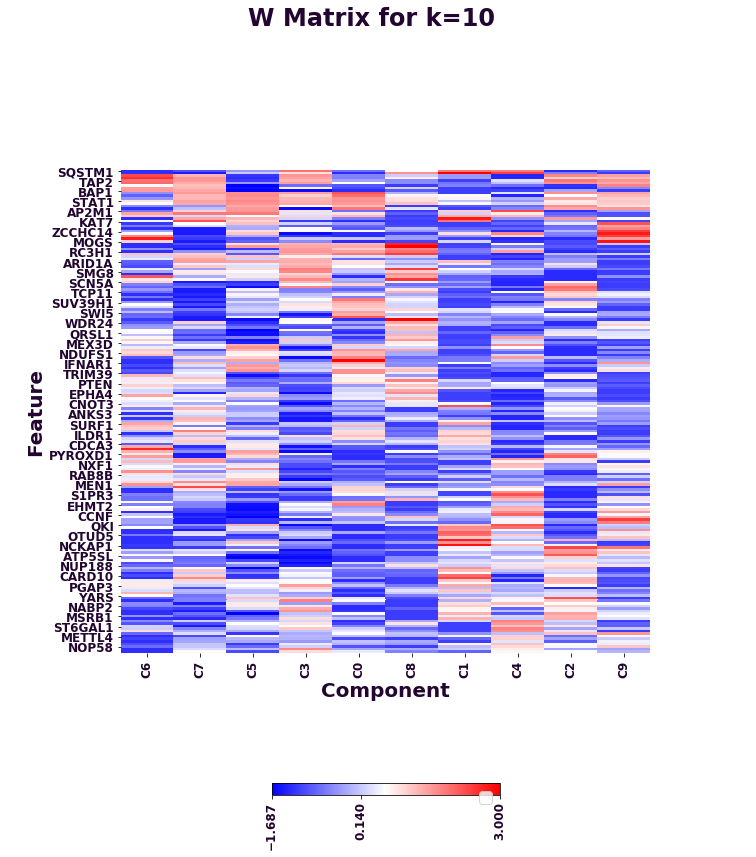

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1152x1152 with 0 Axes>

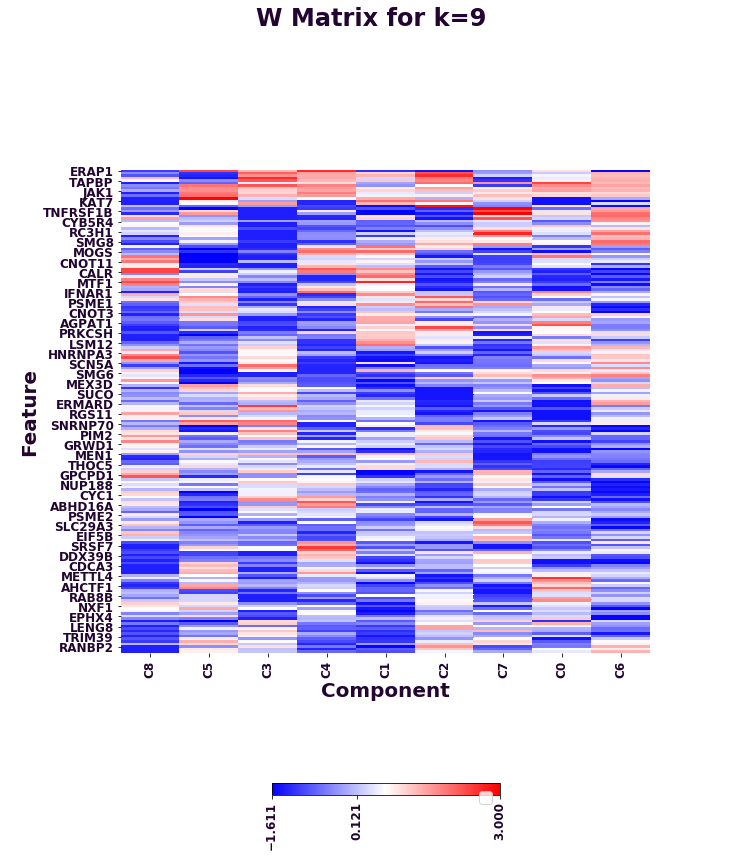

No handles with labels found to put in legend.
No handles with labels found to put in legend.


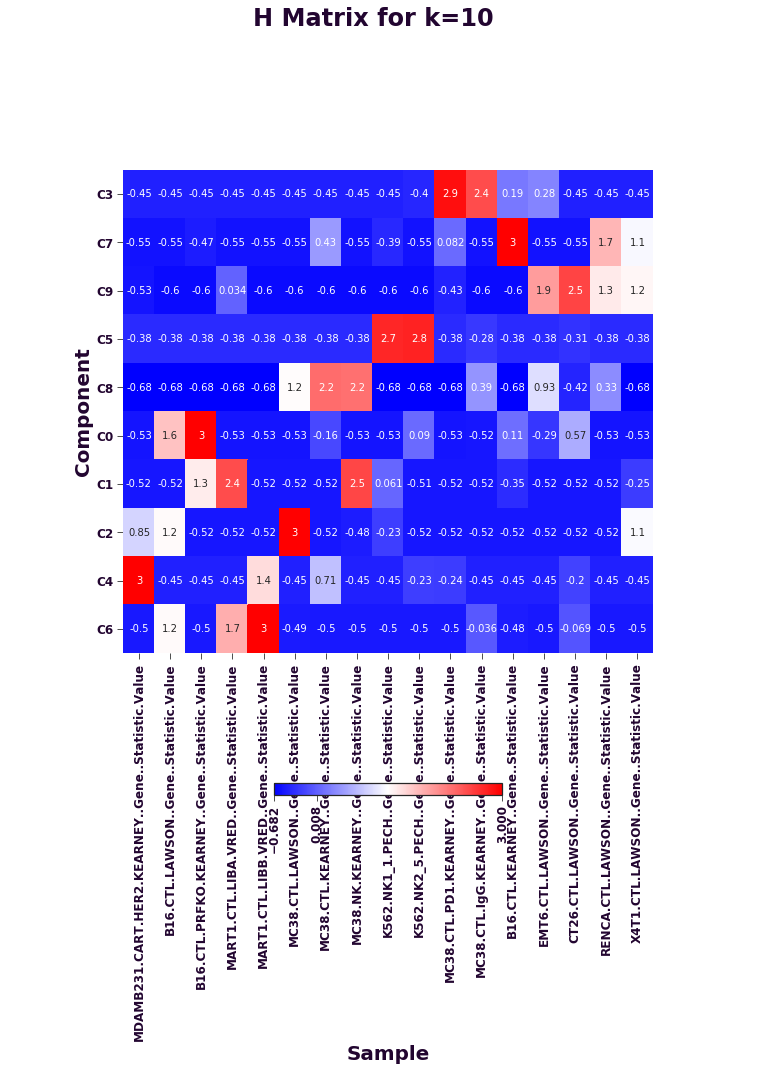

No handles with labels found to put in legend.
No handles with labels found to put in legend.


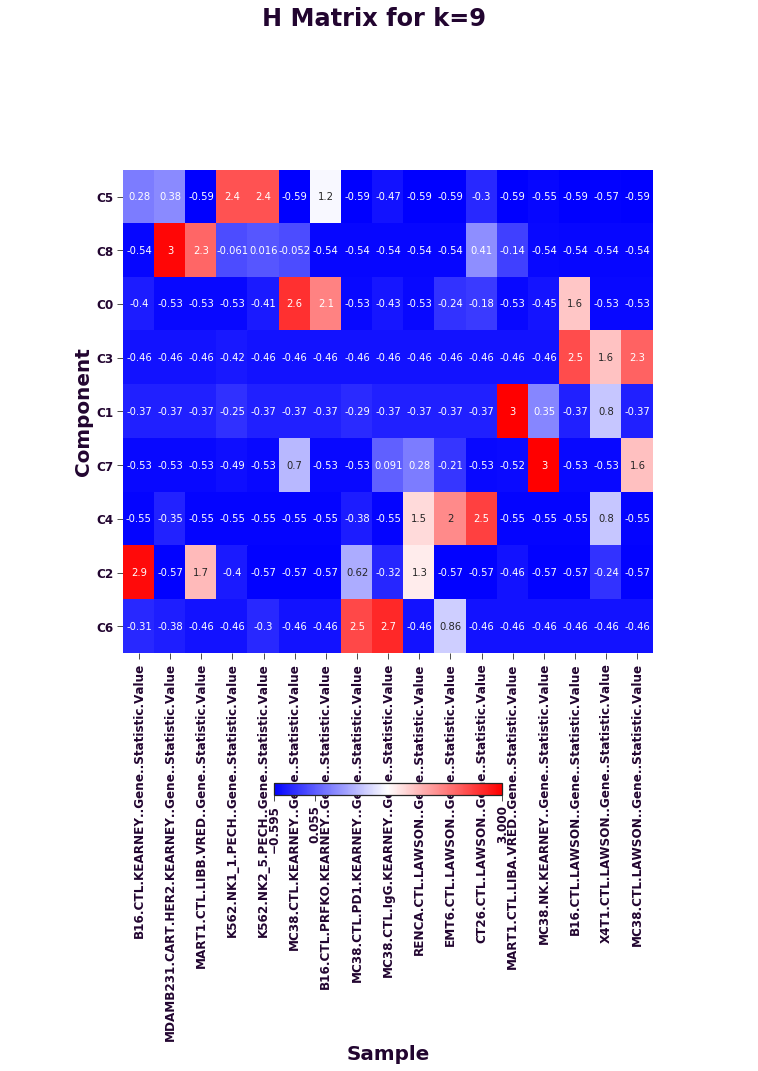

No handles with labels found to put in legend.
No handles with labels found to put in legend.


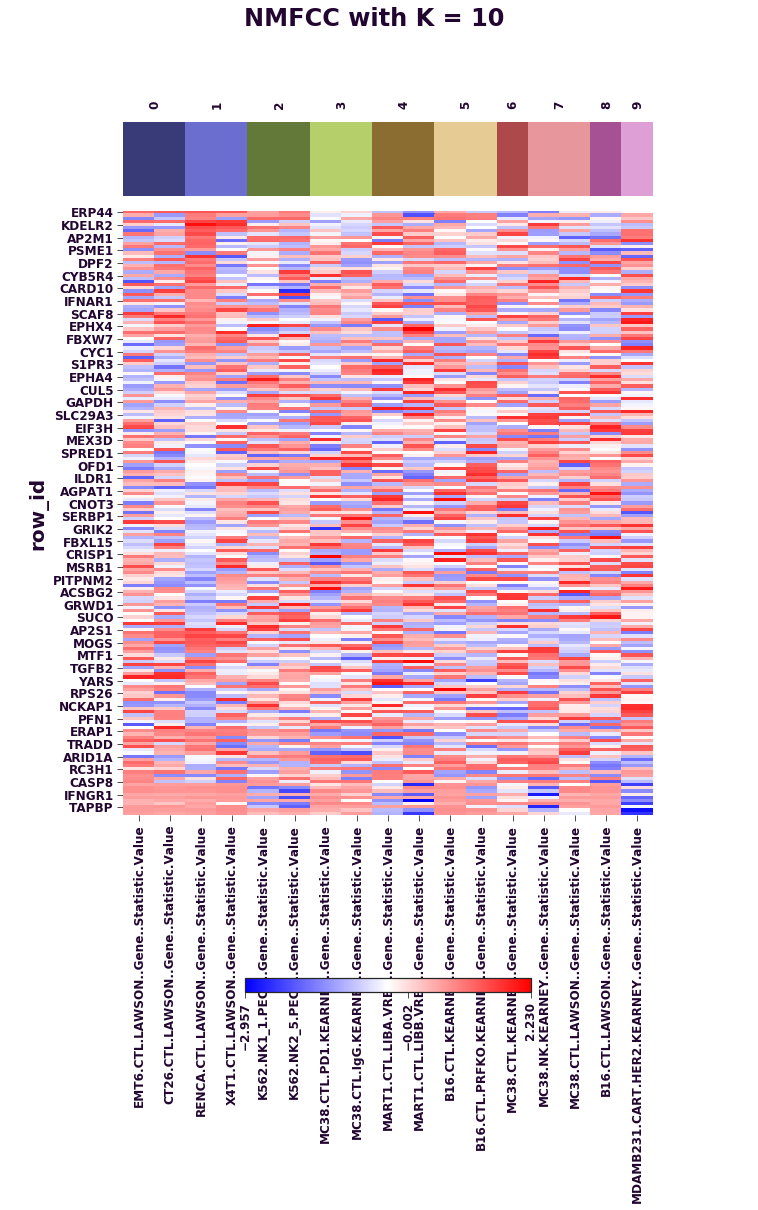

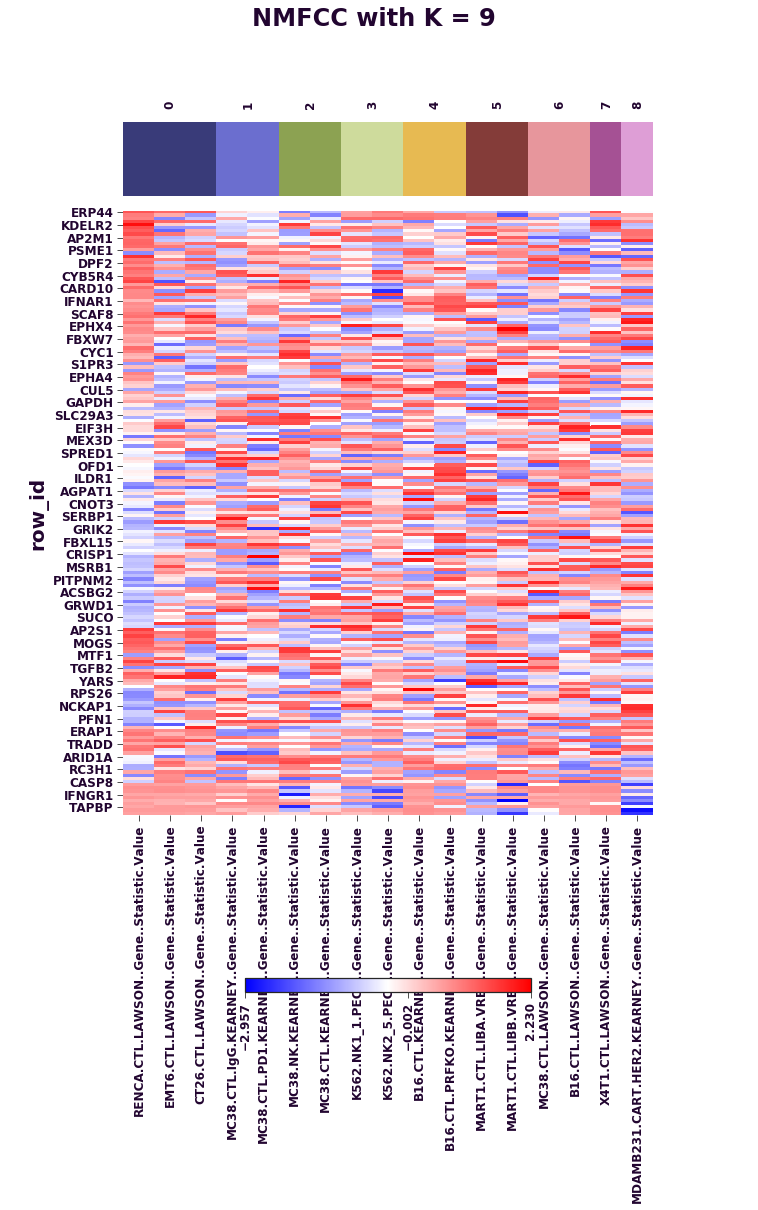

No handles with labels found to put in legend.


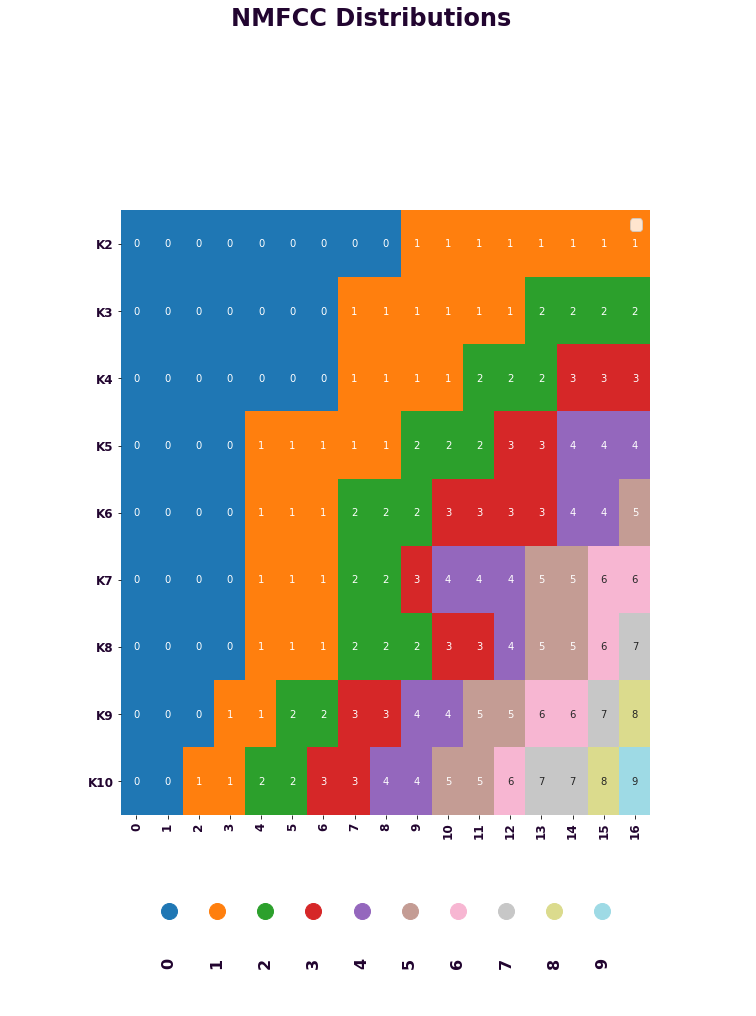

No handles with labels found to put in legend.


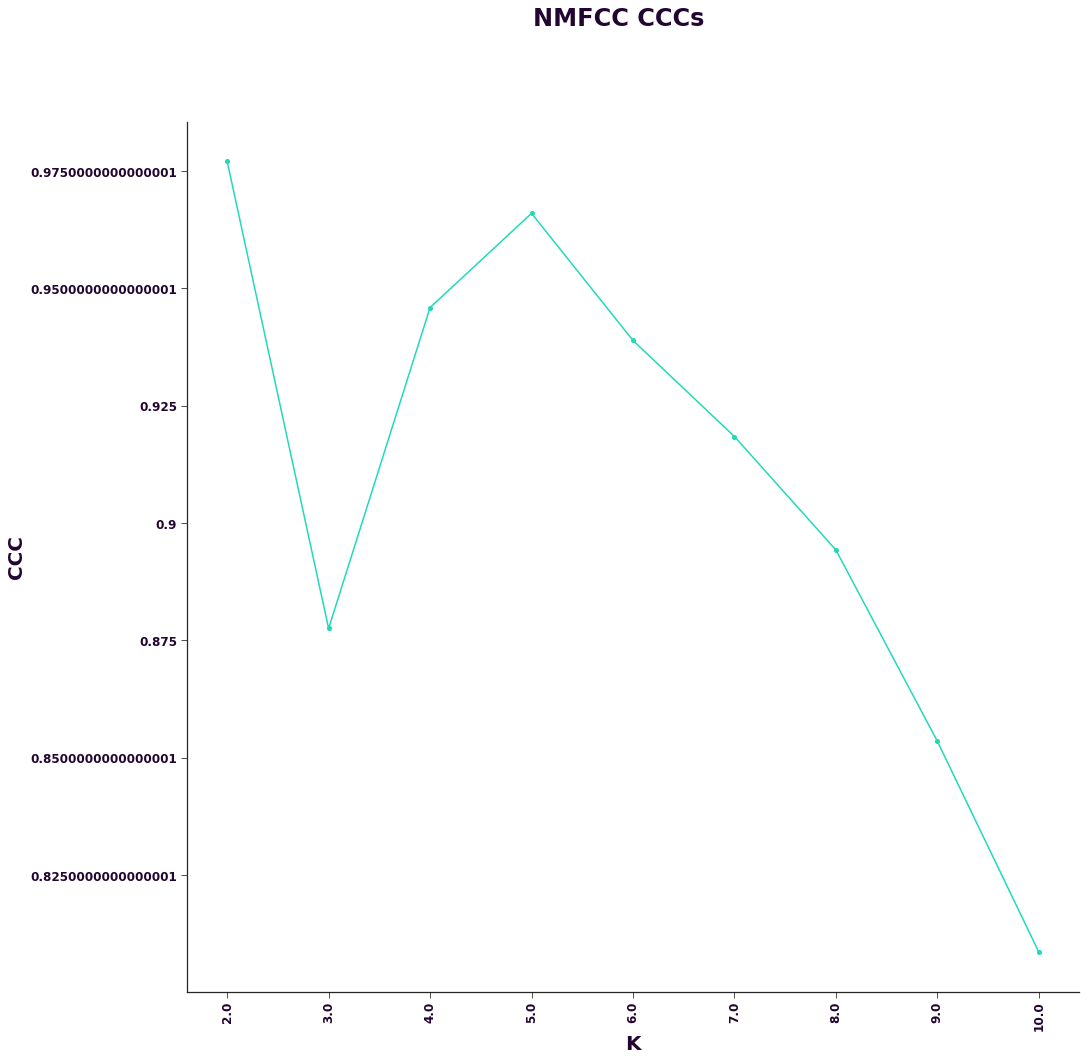

In [6]:
nmfs, nmfccs, cccs = ccal.define_components(
     rpkm__kras_relevant_gene_x_ccle_cellline,
     range(2, 11),
     '../output/nmfccs',
     algorithm='ls',
     n_clusterings=30,
     n_jobs=9,
     random_seed=6137)

### 5. Read H and W matrices of optimal decomposition (k=9) and re-label components

Looking at the results of the prior computation we can see that there is an optimal solution for k= 9 components. So the code below reads the H and W matrices of k=9. Here the components are also relabeled to match the labeling used in the article. The reason for the different labeling is that the original component numbers used in the article were generated using an earlier version of the Onco-GPS code written in the R language that used different random numbers to initiallize the $W$ and $H$ matrices.

In [7]:
w_matrix = pd.read_table('../output/nmfccs/nmf_k5_w.txt', index_col=0)
h_matrix = pd.read_table('../output/nmfccs/nmf_k5_h.txt', index_col=0)

### 6. Plot H and W matrices

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1152x1152 with 0 Axes>

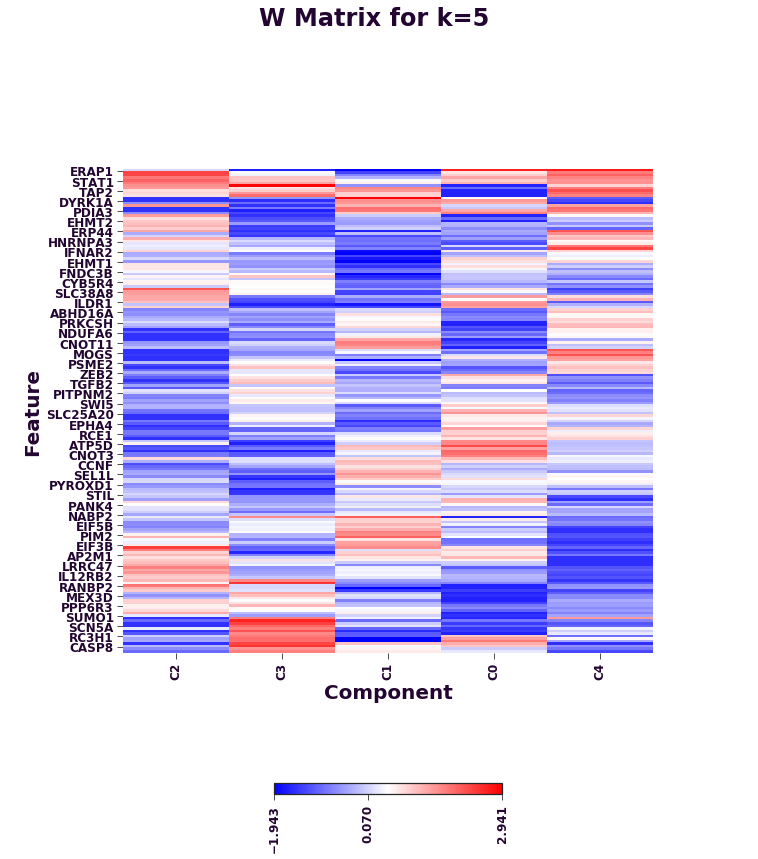

No handles with labels found to put in legend.
No handles with labels found to put in legend.


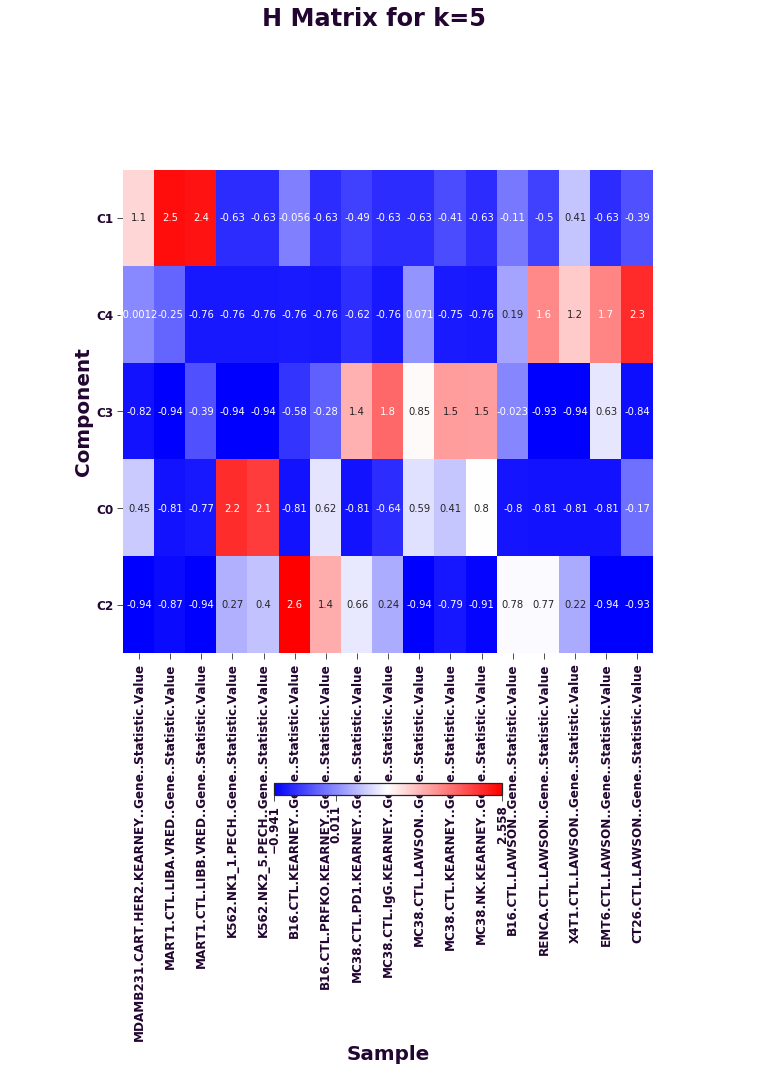

In [8]:
ccal.plot_nmf(w_matrix, h_matrix)

### 6. Compare the NMF components with each other using the information coefficient
This computation generates an association matrix that compares the component profiles against each other using the Information Coefficient. This is Fig S6A in the article and shows that the components are distinct.

Applying <function compute_information_coefficient at 0x7f33491edae8> ...
	1/5 ...
	5/5 - done.


No handles with labels found to put in legend.


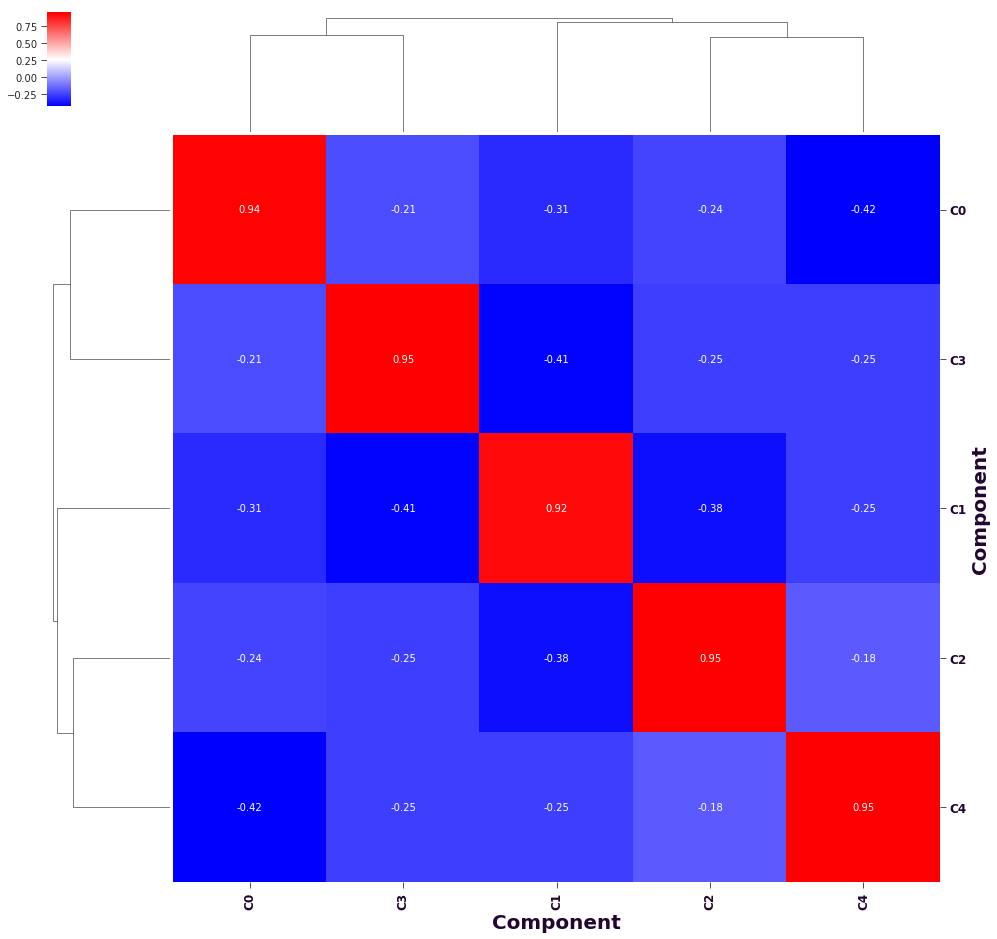

C0        C1        C2        C3        C4
C0  0.942824 -0.307245 -0.236414 -0.214626 -0.420730
C1 -0.307245  0.920183 -0.381128 -0.410028 -0.252892
C2 -0.236414 -0.381128  0.948798 -0.253000 -0.176769
C3 -0.214626 -0.410028 -0.253000  0.951770 -0.249975
C4 -0.420730 -0.252892 -0.176769 -0.249975  0.951913

In [9]:
ccal.make_comparison_panel(
    h_matrix,
    h_matrix,
    axis=1,
    array_2d_0_name='Component',
    array_2d_1_name='Component')

### [Next chapter (4)](4 Annotate transcriptional components.ipynb) 